In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import sweetviz
import folium
import geopandas
from geopy.distance import geodesic
from datetime import datetime

In [2]:
data = pd.read_csv('../../../Desktop/SamX/Bike_Study_Files/big_raw.csv')
data.shape

(5733451, 13)

#### Note:
For the purposes of this analysis, I do not need to be crunching through all 5 million rows of data. A sample of 50,000 is more than enough, and possibly too much for the heatmapping functions. I may need to tweak the parameters of the heatmap, or further restrict the sample size later down the road

In [3]:
data = data.sample(n=50000, replace=False, random_state=42)
data.shape

(50000, 13)

In [4]:
# Convert 'started_at' and 'ended_at' to datetime objects
data['started_at'] = pd.to_datetime(data['started_at'])
data['ended_at'] = pd.to_datetime(data['ended_at'])

# Calculate ride duration in minutes
data['ride_duration'] = (data['ended_at'] - data['started_at']).dt.total_seconds() / 60

# Additional columns for temporal analysis
data['start_date'] = data['started_at'].dt.date
data['start_hour'] = data['started_at'].dt.hour
data['day_of_week'] = data['started_at'].dt.day_name()
data['week_of_year'] = data['started_at'].dt.isocalendar().week

# Preview the data with new columns
data[['ride_id', 'rideable_type', 'member_casual', 'started_at', 'ended_at', 'ride_duration', 'start_date', 'start_hour', 'day_of_week', 'week_of_year']].head()

,ride_id,rideable_type,member_casual,started_at,ended_at,ride_duration,start_date,start_hour,day_of_week,week_of_year
3479634,DF3F95B75B6DFBBC,electric_bike,member,2022-08-09 09:54:27,2022-08-09 09:57:36,3.150000,2022-08-09,9,Tuesday,32
2954009,E62A501C91C9283A,electric_bike,casual,2022-07-05 17:32:36,2022-07-05 17:39:24,6.800000,2022-07-05,17,Tuesday,27
4233289,2332C4F5E2EE3457,classic_bike,member,2022-09-15 17:05:35,2022-09-15 17:20:22,14.783333,2022-09-15,17,Thursday,37
4282455,063065272EF72853,classic_bike,member,2022-09-08 13:51:19,2022-09-08 13:55:26,4.116667,2022-09-08,13,Thursday,36
2265302,AFC7A810123AB8EB,classic_bike,casual,2022-06-19 11:36:21,2022-06-19 12:39:10,62.816667,2022-06-19,11,Sunday,24


In [5]:
data.shape

(50000, 18)

In [7]:
data.rideable_type.value_counts()

electric_bike    25436
classic_bike     22953
docked_bike       1611
Name: rideable_type, dtype: int64

Let's start by getting a sense for who is using these e-bikes

C:\Users\sshanks\AppData\Local\Temp\ipykernel_26956\3599449609.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  e_bikes_members['day_of_week'] = e_bikes_members['started_at'].dt.dayofweek
C:\Users\sshanks\AppData\Local\Temp\ipykernel_26956\3599449609.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  e_bikes_members_weekdays['hour_of_day'] = e_bikes_members_weekdays['started_at'].dt.hour


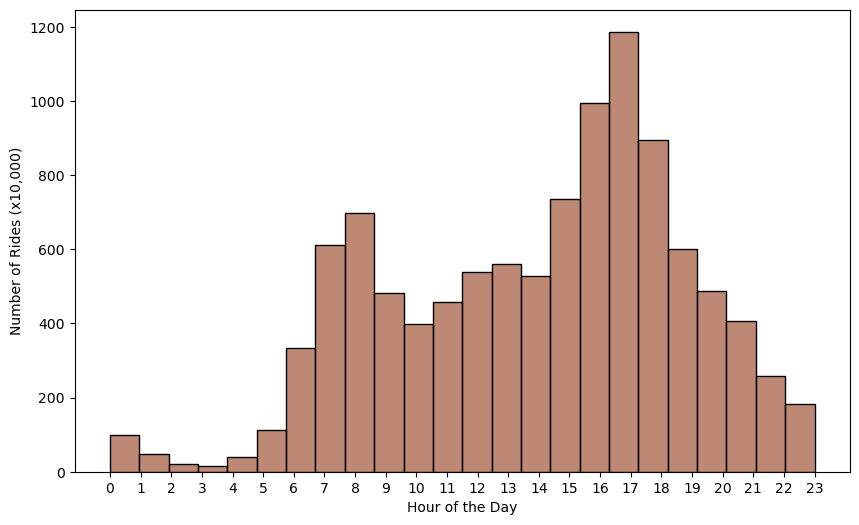

In [8]:
# Filter for only classic bikes used by members
e_bikes_members = data[(data['rideable_type'] == 'electric_bike') & (data['member_casual'] == 'member')]

# Filter for Monday to Friday
e_bikes_members['day_of_week'] = e_bikes_members['started_at'].dt.dayofweek
e_bikes_members_weekdays = e_bikes_members[e_bikes_members['day_of_week'] < 5]

# Extract hour of day
e_bikes_members_weekdays['hour_of_day'] = e_bikes_members_weekdays['started_at'].dt.hour

# Plotting histogram
plt.figure(figsize=(10, 6))
sns.histplot(e_bikes_members_weekdays['hour_of_day'], bins=24, kde=False, color='#a76046')
#plt.title('Usage of Classic Bikes by Members (Monday-Friday)')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Rides (x10,000)')
plt.xticks(range(0, 24))
plt.grid(False)
plt.show()

In [9]:
e_bikes_members.shape

(14301, 18)

In [10]:
e_bikes = data[(data['rideable_type'] == 'electric_bike')]
e_bikes.shape

(25436, 18)

In [12]:
e_bikes.isnull().sum()

ride_id                  0
rideable_type            0
started_at               0
ended_at                 0
start_station_name    7519
start_station_id      7519
end_station_name      7980
end_station_id        7980
start_lat                0
start_lng                0
end_lat                  0
end_lng                  0
member_casual            0
ride_duration            0
start_date               0
start_hour               0
day_of_week              0
week_of_year             0
dtype: int64

In [13]:
percentage_with_end_station_name = e_bikes['end_station_name'].notna().mean() * 100

percentage_with_end_station_name

68.62714263248938

In [39]:
eb_start_yes = e_bikes[e_bikes['start_station_name'].notnull()]
eb_start_yes.shape

(17917, 19)

In [59]:
# Calculate the three scenarios
total_electric_with_start = len(e_bikes)
match_count = (e_bikes['start_station_name'] == e_bikes['end_station_name']).sum()
different_count = ((e_bikes['start_station_name'] != e_bikes['end_station_name']) & 
                   e_bikes['end_station_name'].notnull()).sum()
no_end_station_count = e_bikes['end_station_name'].isnull().sum()

# Calculate percentages
percent_match = (match_count / total_electric_with_start) * 100
percent_different = (different_count / total_electric_with_start) * 100
percent_no_end_station = (no_end_station_count / total_electric_with_start) * 100

percent_match, percent_different, percent_no_end_station

(3.699481050479635, 64.92766158200976, 31.372857367510615)

In [60]:
# Calculate the three scenarios
total_electric_with_start = len(eb_start_yes)
match_count = (eb_start_yes['start_station_name'] == eb_start_yes['end_station_name']).sum()
different_count = ((eb_start_yes['start_station_name'] != eb_start_yes['end_station_name']) & 
                   eb_start_yes['end_station_name'].notnull()).sum()
no_end_station_count = eb_start_yes['end_station_name'].isnull().sum()

In [61]:
# Calculate percentages
percent_match = (match_count / total_electric_with_start) * 100
percent_different = (different_count / total_electric_with_start) * 100
percent_no_end_station = (no_end_station_count / total_electric_with_start) * 100

results = (percent_match, percent_different, percent_no_end_station)

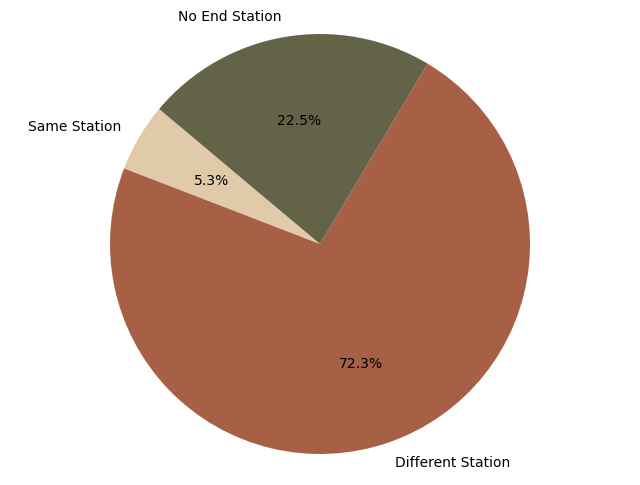

In [62]:
# Creating a 2D pie chart with the provided percentages

# Tuple of results and their corresponding labels
#results = (3.7, 64.9, 31.4)
labels = ['Same Station', 'Different Station', 'No End Station']
colours = ['#e0caa9', '#a76046', '#636348']

# Create a pie chart
plt.figure(figsize=(8, 6))
plt.pie(results, labels=labels, autopct='%1.1f%%', startangle=140, colors=colours)
#plt.title('Distribution of Electric Bike Rides by End Station Status')
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.

# Show the pie chart
plt.show()



The following will create a new data feature that is the distance betweent the starting and ending latitude/longitude points.

In [24]:
# Redefining the Haversine function to handle potential issues
def haversine(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6371 * c
    miles = km * 0.621371
    return miles

In [27]:
# Applying the Haversine function to the electric bike data
try:
    e_bikes['distance_miles'] = e_bikes.apply(
        lambda row: haversine(row['start_lat'], row['start_lng'], row['end_lat'], row['end_lng']), axis=1)
except Exception as e:
    error_message = str(e)

# Checking if the operation was successful or if there was an error
if 'e_bikes' in locals():
    result = e_bikes[['ride_id', 'distance_miles']].head()
else:
    result = error_message

result

C:\Users\sshanks\AppData\Local\Temp\ipykernel_26956\597787971.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  e_bikes['distance_miles'] = e_bikes.apply(


,ride_id,distance_miles
3479634,DF3F95B75B6DFBBC,0.462689
2954009,E62A501C91C9283A,0.928844
3711879,060C412712E514E3,1.804045
1548221,DFF76679ACF3456A,1.188627
187158,C39C9D29A5DC9733,0.636397


In [40]:
eb_start_yes.shape

(17917, 19)

In [139]:
# Aggregate Data by Station Name
aggregated_data = eb_start_yes.groupby('start_station_name').apply(
    lambda df: pd.Series({
        'Starts': len(df),
        'Same Station': (df['start_station_name'] == df['end_station_name']).sum(),
        'Different Station': ((df['start_station_name'] != df['end_station_name']) & df['end_station_name'].notnull()).sum(),
        'No End Station': df['end_station_name'].isnull().sum(),
        'No End Pct': (df['end_station_name'].isnull().sum() / len(df)),
        'start_lat': df['start_lat'],
        'start_lng': df['start_lng']
    })
).reset_index()

In [140]:
top_20_percent

,start_station_name,Starts,Same Station,Different Station,No End Station,No End Pct,start_lat,start_lng
744,Streeter Dr & Grand Ave,204,30,132,42,0.205882,3316649 41.892225 3260783 41.892193 2995...,3316649 -87.612317 3260783 -87.611869 2995...
204,Damen Ave & Pierce Ave,104,4,69,31,0.298077,1352900 41.909391 141002 41.909399 3768...,1352900 -87.677693 141002 -87.677736 3768...
146,Clark St & Elm St,129,5,94,30,0.232558,3973389 41.902746 4581229 41.902878 2873...,3973389 -87.631636 4581229 -87.631649 2873...
788,Wells St & Concord Ln,144,5,110,29,0.201389,5196969 41.911938 4413969 41.912070 2047...,5196969 -87.634788 4413969 -87.634863 2047...
757,University Ave & 57th St,55,1,25,29,0.527273,3158488 41.791483 5652976 41.791498 7045...,3158488 -87.599900 5652976 -87.599842 7045...
...,...,...,...,...,...,...,...,...
255,Ewing Ave & Burnham Greenway,9,0,1,8,0.888889,3156796 41.881413 1361087 41.871347 1723...,3156796 -87.674816 1361087 -87.673930 1723...
394,Lakefront Trail & Wilson Ave,27,2,17,8,0.296296,849816 41.965793 1263834 41.965833 4468...,849816 -87.645558 1263834 -87.645515 4468...
391,Lake Park Ave & 53rd St,17,0,9,8,0.470588,4707225 41.799528 2430511 41.799587 1164...,4707225 -87.586406 2430511 -87.586378 1164...
494,Milwaukee Ave & Rockwell St,31,1,22,8,0.258065,5571308 41.920284 1771126 41.920294 1795...,5571308 -87.692677 1771126 -87.692589 1795...


In [141]:
# Sort Stations by 'No End Station' Count
sorted_stations = aggregated_data.sort_values(by='No End Pct', ascending=False)

# Select Top and Bottom 20%
top_20_percent = sorted_stations.head(len(sorted_stations) // 5)
bottom_20_percent = sorted_stations.tail(len(sorted_stations) // 5)

# Extract the required data for visualization
top_20_data = top_20_percent[['Same Station', 'Different Station', 'No End Station']].sum()
bottom_20_data = bottom_20_percent[['Same Station', 'Different Station', 'No End Station']].sum()

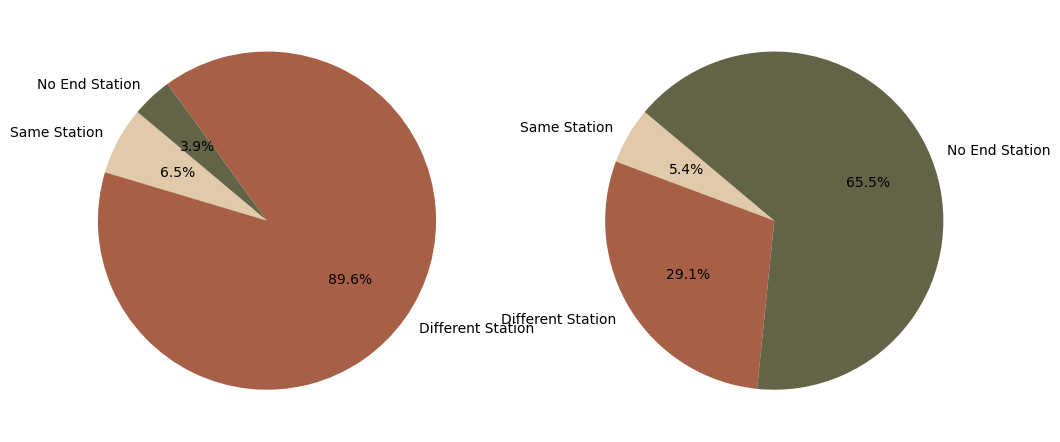

In [142]:
# Create Subplots with Pie Charts
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Pie chart for bottom 20%
axs[0].pie(bottom_20_data, labels=bottom_20_data.index, autopct='%1.1f%%', startangle=140, colors=colours)

# Pie chart for top 20%
axs[1].pie(top_20_data, labels=top_20_data.index, autopct='%1.1f%%', startangle=140, colors=colours)

# Display the pie charts
plt.show()


In [143]:
top_20_percent.columns

Index(['start_station_name', 'Starts', 'Same Station', 'Different Station',
       'No End Station', 'No End Pct', 'start_lat', 'start_lng'],
      dtype='object')

In [144]:
# Extracting latitude and longitude for start stations
start_stations_lat_lng = data[['start_station_name', 'start_lat', 'start_lng']].drop_duplicates()

# Filtering for the top 20 stations with largest discrepancy
top_20_stations_lat_lng = start_stations_lat_lng[start_stations_lat_lng['start_station_name'].isin(top_20_percent.start_station_name)]

top_20_stations_lat_lng

,start_station_name,start_lat,start_lng
4282455,Ellis Ave & 58th St,41.788746,-87.601334
3278803,Cornell Ave & Hyde Park Blvd,41.802406,-87.586924
705635,Kedzie Ave & 57th St,41.790000,-87.700000
568733,Ellis Ave & 53rd St,41.799336,-87.600958
4766711,Lavergne Ave & 46th St,41.810000,-87.750000
...,...,...,...
1357630,Woodlawn Ave & Lake Park Ave,41.814051,-87.597026
116269,Western Ave & 104th St,41.704644,-87.681126
2411602,Cornell Ave & Hyde Park Blvd,41.802396,-87.586499
1433758,Ellis Ave & 60th St,41.785141,-87.601082


In [145]:
# Extracting the station names for the top and bottom 10 stations
top_20_station_names = top_20_percent.start_station_name
bottom_20_station_names = bottom_20_percent.start_station_name

In [146]:
# Filtering the latitude and longitude for these stations
top_20_stations_lat_lng = start_stations_lat_lng[start_stations_lat_lng['start_station_name'].isin(top_20_station_names)]
bottom_20_stations_lat_lng = start_stations_lat_lng[start_stations_lat_lng['start_station_name'].isin(bottom_20_station_names)]

In [147]:
from IPython.display import HTML

In [148]:
# Ensuring unique entries for each station
top_20_stations_lat_lng_unique = top_20_stations_lat_lng.drop_duplicates(subset=['start_station_name'])
bottom_20_stations_lat_lng_unique = bottom_20_stations_lat_lng.drop_duplicates(subset=['start_station_name'])

# Creating a map centered around the general area of the stations
map_center_lat = start_stations_lat_lng['start_lat'].mean()
map_center_lng = start_stations_lat_lng['start_lng'].mean()
station_map_discrepancy = folium.Map(location=[map_center_lat, map_center_lng], zoom_start=12)

# Adding blue markers for top 20 
for _, row in top_20_stations_lat_lng_unique.iterrows():
    folium.Marker(
        location=[row['start_lat'], row['start_lng']],
        popup=row['start_station_name'],
        icon=folium.Icon(color="blue")
    ).add_to(station_map_discrepancy)

# Adding red markers for bottom 20 
for _, row in bottom_20_stations_lat_lng_unique.iterrows():
    folium.Marker(
        location=[row['start_lat'], row['start_lng']],
        popup=row['start_station_name'],
        icon=folium.Icon(color="red")
    ).add_to(station_map_discrepancy)

    

HTML('<div style="height: 900px; overflow-y: scroll;">Your Content</div>')
station_map_discrepancy